# Snippets 

## Summarizing Time Series Data with Snippets

This tutorial is adapted from the [Matrix Profile XIII](https://www.cs.ucr.edu/~eamonn/Time_Series_Snippets_10pages.pdf) paper and replicates Figures 7 and 13.

One of the most common questions on a time series data is to find a set of typical data/patterns (referred to as snippets in the paper). Sometimes, it is useful to summarize a large time series into a few representative data. So, it can be visualized more easily and some insights might be discovered as well. 

For instance, the respiration data of a person recorded during his sleep can be reported by showing only the top-2 snippets. As an another example, snippets can be used to find different stages in the walking-nordic walking-skipping-running cycle of a person. Particularly, the y-axis acceleration data recorded by a chest-worn sensor can be summarized into top-4 snippets where each snippet shows a different type of exercise. 

The "snippet-finder" algorithm proposed in the paper can be utilized to summarize a time series into a user-defined number of snippets. 


It is worthwhile to note what snippet is __NOT__ :
* Snippet is a different task than clustering. Although clustering is a common approach to find representative patterns, one should specify the beginning and ending of subsequences and then apply clustering on the set of subseuqences. However, such approach is not appropriate where the boundaries of subsequences are not clear. For instance, algorithms specialized in clustering the electricity demand data into seasons are more complex and requires more domain knowledge (for example: the subsequences must be exactly one-week long.) However, the snippets algorithm is domain-free and it can be used to better explore and analyze data.

* The snippets are different than semantic segmentation proposed in [Matrix Profile VIII](https://www.cs.ucr.edu/~eamonn/Segmentation_ICDM.pdf). In semantic segmentation, the task is to find boundary locations, not in explaining them, or producing representative patterns.


To demonstrate the usefulness of Snippets, we first create a toy data used in the original paper and will use the [STUMPY](https://pypi.org/project/stumpy/) library to discover the snippets in the data. This tutorial replicates the figures 7,8 and 13 of the original paper. Then, we use a real-world data used in one of the case studies of the original paper. This will replicate ...

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [5]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, resample_poly

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

## Retrieve the Data

It is the same toy data set used in the original paper. 

In [9]:
df = pd.read_csv("https://zenodo.org/record/4662217/files/snippets.csv?download=1")
df.head()

,toy
0,0.347609
1,0.350937
2,0.357541
3,0.367308
4,0.380056


## Visualizing the Raw Data

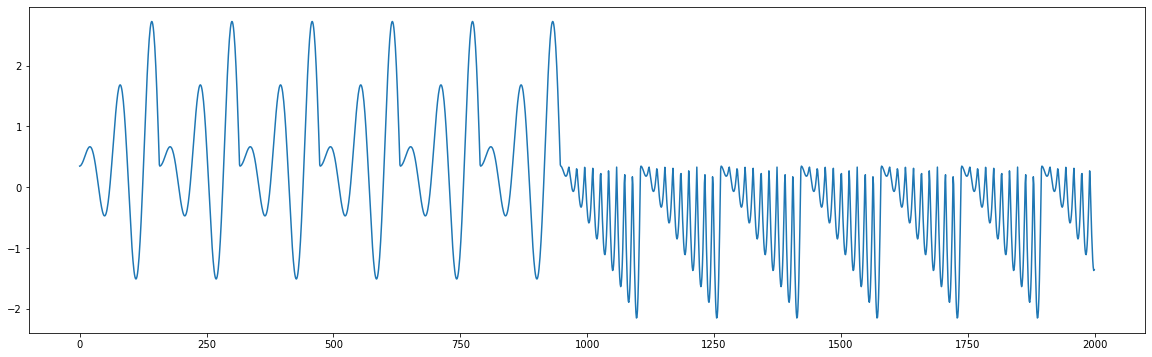

In [16]:
plt.plot(df)
plt.show()

## Adding noise to the data


In [11]:
def warp_add_noise(T):
    T = np.asarray(T).flatten()
    idx = np.arange(T.shape[0])
    np.random.shuffle(idx)
    idx = np.sort(idx[:-np.floor(T.shape[0] * 0.1).astype(int)])
    warped_T = resample_poly(T[idx], T.shape[0], idx.shape[0])
    noise = np.random.normal(0, 0.05, warped_T.shape)
    return warped_T + noise

In [14]:
T = warp_add_noise(df)

## Visualizing the Data with noise

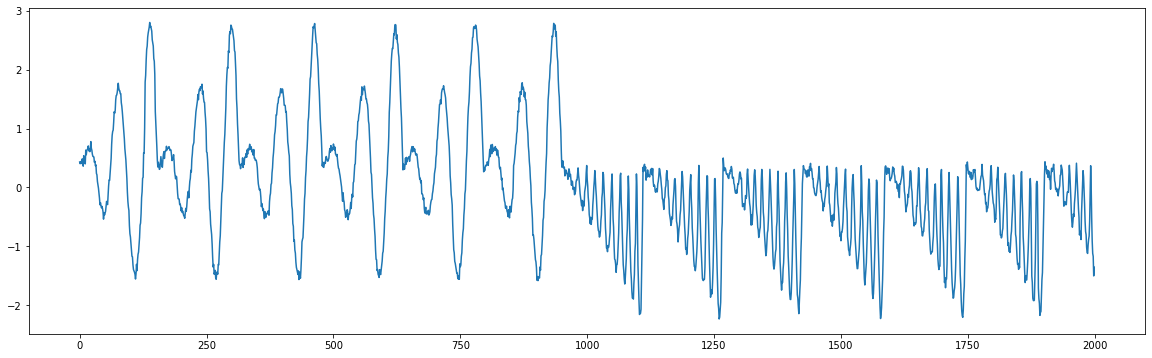

In [13]:
plt.plot(T)
plt.show()

As one can notice, the toy time series above contains two distinct parts, where each part is constructed by a repeatative subsequence. We expect that the snippet algorithm can discover the representative subsequences.

## Finding Snippets

In [37]:
T = warp_add_noise(df) 
m = 200 
k = 2 
s = 70 

snippets, indices, profiles, fractions, areas = stumpy.snippets(T, m, k, s=s)

## Plotting the snippets

The following figure replicates Fig. 7 of the original paper.

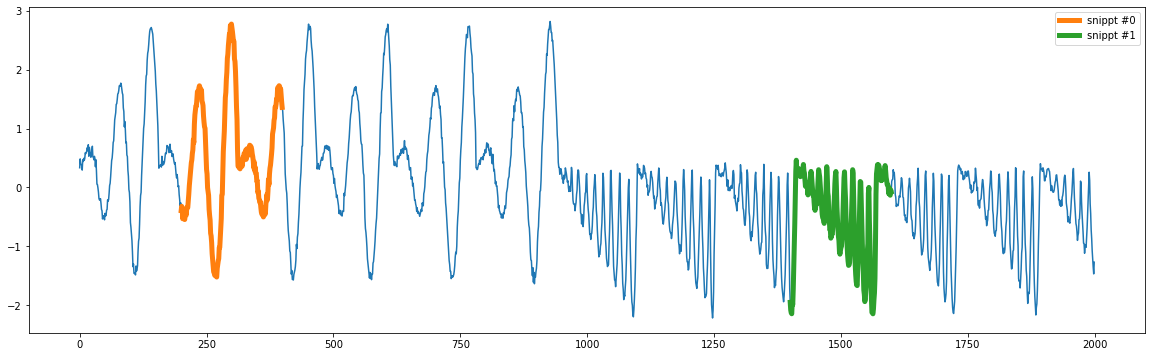

In [38]:
plt.plot(T)
for i in range(k):
    idx = indices[i]
    plt.plot(range(idx, idx + m), T[idx : idx + m], lw=5, label='snippt #{}'.format(i))

plt.legend()
plt.show()

## Plotting the MPdist profile of snippets


The following figure replicates Fig. 8 of the original paper.

The snippet algorithm utilizes MPdist as the distance between two susbequences as it is robust to spikes, warping, linear trends, etc. Let's see how the MPdist profile does look like for the two snippets shown in the previous figure.

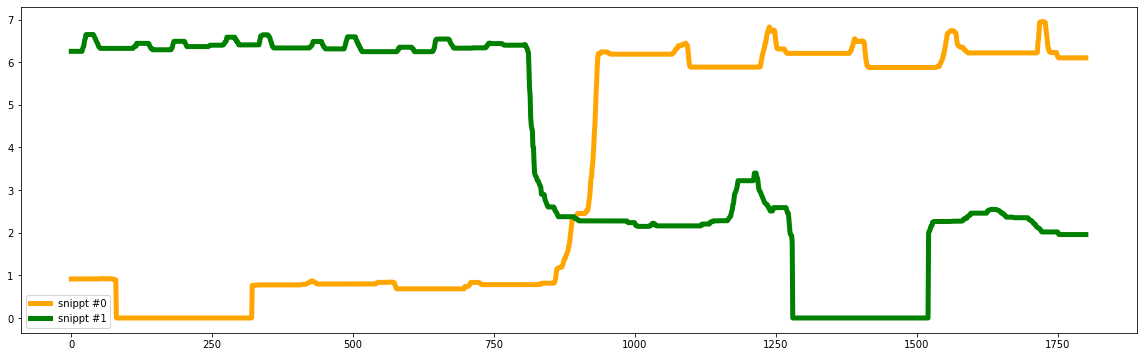

In [39]:
color_vec = ['orange','green']
for i in range(k):
    plt.plot(profiles[i],c=color_vec[i], lw=5, label='snippt #{}'.format(i))

plt.legend()
plt.show()

As illustrated in the figure above, the MPdist profiles can provide useful insights about the the snippets. Note that the two profiles are mutually exclusive, when one in high, the other is low. These two profiles offer strong clues to the locations of potential time series snippets. They are both approximately “step” functions with their respective low region corresponding to a region that contains subsequences that are similar to the two query patterns.

## Finding optimal k (number of snippets)

To find the optimal number of snippets, a large enough k can be selected. Then, the area under the curve corresponding to each MPdist profile can be used to find the optimal number of snippets. 

The following two figures replicate Fig. 13 (left) and Fig. 13 (right), respectively.

In [47]:
snippets, indices, profiles, fractions, areas = stumpy.snippets(T, m, k=9, s=s)

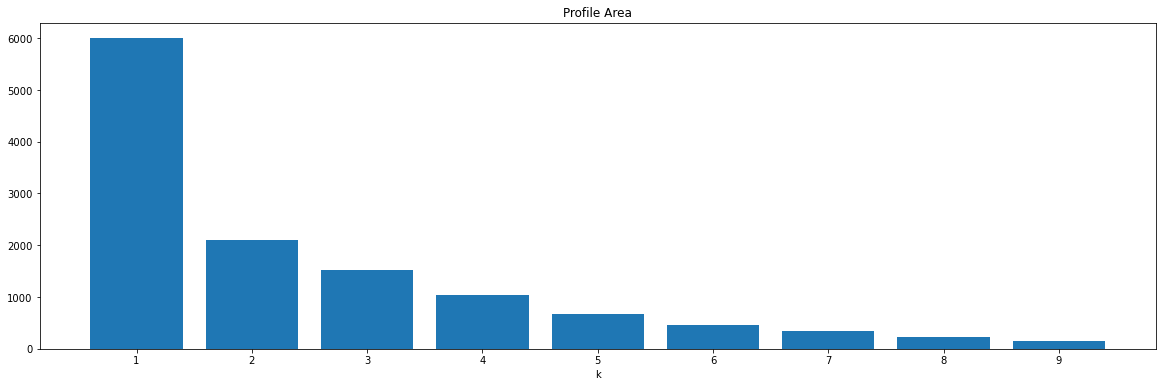

In [48]:
plt.bar(range(1, 10), areas, tick_label=range(1,10))
plt.xlabel("k")
plt.title('Profile Area')
plt.show()

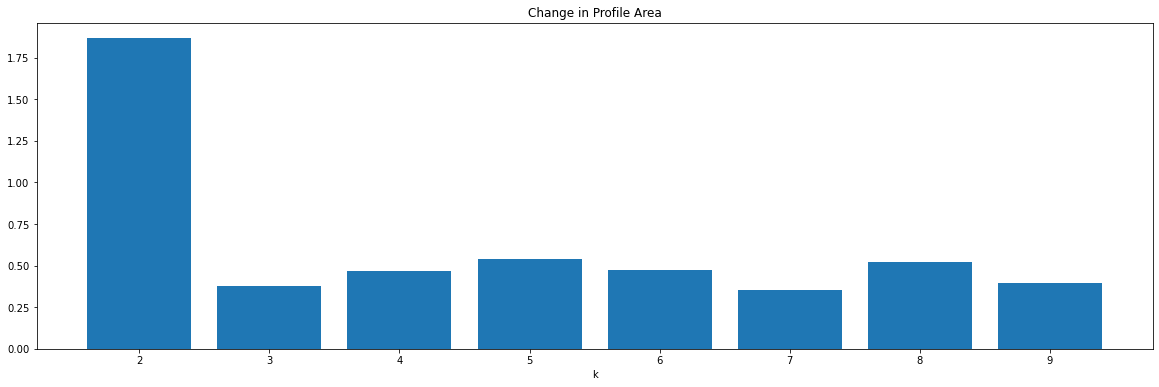

In [49]:
plt.bar(range(2, 10), areas[:-1]/areas[1:] - 1.0, tick_label=range(2,10))
plt.xlabel("k")
plt.title('Change in Profile Area')
plt.show()

As illustrated above, changing the number of snippets from k=1 to k=2 can significantly change the area under the curve; however, the change in the area is negligible from k=2 to k=3 and so forth. Therefore, the optimal number of snippets is two.